# Haptic Signal VAE — Colab Training

This notebook runs the full training pipeline on Google Colab.

**Data source:** Cloned directly from [HapticGen/hapticgen-dataset](https://github.com/HapticGen/hapticgen-dataset) — no Google Drive needed for data.

**Steps:**
1. Clone code repo + dataset repo from GitHub
2. Install dependencies
3. Run training
4. Evaluate and listen to results
5. (Optional) Save outputs to Google Drive

In [1]:
# 1. Clone code repo (or pull latest)
import os

REPO_URL = "https://github.com/cindy-77jiayi/thesis_hapticAE.git"
REPO_DIR = "/content/thesis_hapticAE"

if os.path.exists(REPO_DIR):
    !cd {REPO_DIR} && git pull
else:
    !git clone {REPO_URL} {REPO_DIR}

os.chdir(REPO_DIR)
print(f"Working directory: {os.getcwd()}")

Cloning into '/content/thesis_hapticAE'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 134 (delta 48), reused 112 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (134/134), 2.20 MiB | 7.33 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Working directory: /content/thesis_hapticAE


In [2]:
# 2. Clone dataset directly from GitHub (no Google Drive needed)
DATASET_URL = "https://github.com/HapticGen/hapticgen-dataset.git"
DATASET_DIR = "/content/hapticgen-dataset"

if os.path.exists(DATASET_DIR):
    !cd {DATASET_DIR} && git pull
else:
    !git clone {DATASET_URL} {DATASET_DIR}

# Data path for training
DATA_DIR = os.path.join(DATASET_DIR, "expertvoted")
print(f"Dataset: {DATA_DIR}")
print(f"Files: {len(os.listdir(DATA_DIR)) if os.path.exists(DATA_DIR) else 'NOT FOUND'}")

Cloning into '/content/hapticgen-dataset'...
remote: Enumerating objects: 9056, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 9056 (delta 0), reused 3 (delta 0), pack-reused 9051 (from 1)
Receiving objects: 100% (9056/9056), 80.19 MiB | 20.74 MiB/s, done.
Resolving deltas: 100% (2232/2232), done.
Dataset: /content/hapticgen-dataset/expertvoted
Files: 2594


In [3]:
# 3. Install dependencies
!pip install -q -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 15.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 9.10.0 which is incompatible.


In [4]:
# 4. Configure paths
OUTPUT_DIR = "/content/outputs"  # Colab local storage (fast)
CONFIG = "configs/vae_balanced.yaml"

os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Data:   {DATA_DIR}")
print(f"Output: {OUTPUT_DIR}")
print(f"Config: {CONFIG}")

Data:   /content/hapticgen-dataset/expertvoted
Output: /content/outputs
Config: configs/vae_balanced.yaml


In [5]:
# 5. Run training
!python scripts/train.py --config {CONFIG} --data_dir {DATA_DIR} --output_dir {OUTPUT_DIR}

📂 Collecting WAV files from: /content/hapticgen-dataset/expertvoted
   Found 585 clean WAV files
   Train: 468, Val: 117
   Global RMS: 0.030831
   Batches: train=14, val=4
🖥️  Device: cuda
   Model: VAE, params: 2,818,097
[Epoch 001/200 |   0.5%] lr=2.00e-04 | train=3.159795 | val=3.220029
[Epoch 010/200 |   5.0%] lr=2.00e-04 | train=2.736987 | val=3.112421
[Epoch 020/200 |  10.0%] lr=2.00e-04 | train=2.178032 | val=2.417390
[Epoch 030/200 |  15.0%] lr=2.00e-04 | train=1.981635 | val=2.269826
[Epoch 040/200 |  20.0%] lr=2.00e-04 | train=1.862339 | val=1.982000
[Epoch 050/200 |  25.0%] lr=2.00e-04 | train=1.804367 | val=2.086031
[Epoch 060/200 |  30.0%] lr=2.00e-04 | train=1.695344 | val=1.972497
[Epoch 070/200 |  35.0%] lr=1.00e-04 | train=1.568094 | val=1.990456
[Epoch 080/200 |  40.0%] lr=1.00e-04 | train=1.426684 | val=1.796637
[Epoch 090/200 |  45.0%] lr=1.00e-04 | train=1.478031 | val=1.891364
[Epoch 100/200 |  50.0%] lr=1.00e-04 | train=1.450011 | val=1.928866
[Epoch 110/200 |  

Using checkpoint: /content/outputs/vae_balanced/best_model.pt


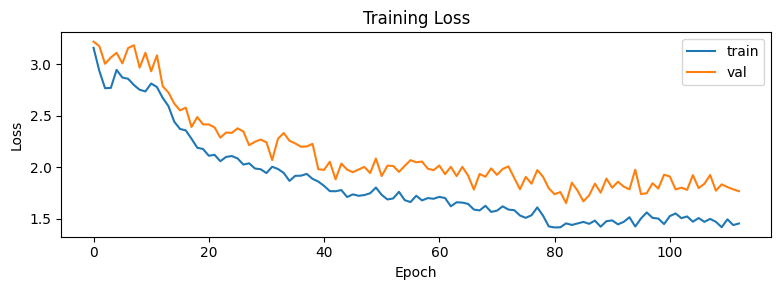

In [6]:
# 6. Evaluate: load results and visualize
import os, sys, glob

# Ensure repo is on Python path
REPO_DIR = "/content/thesis_hapticAE"
os.chdir(REPO_DIR)
if REPO_DIR not in sys.path:
    sys.path.insert(0, REPO_DIR)

import numpy as np
import torch
from torch.utils.data import DataLoader

from src.utils.config import load_config
from src.utils.seed import set_seed
from src.data.preprocessing import collect_clean_wavs, estimate_global_rms
from src.data.dataset import HapticWavDataset
from src.models.conv_vae import ConvVAE
from src.eval.evaluate import evaluate_reconstruction, print_metrics
from src.eval.visualize import plot_loss_curves, plot_waveform_comparison
from src.eval.audio import play_ab_comparison

# CONFIG, OUTPUT_DIR, DATA_DIR are set in Cell 4 — no need to redefine
config = load_config(CONFIG)
set_seed(config['seed'])

# Find checkpoint matching current config's run_name
run_name = config.get('run_name', 'vae_default')
ckpt_path = os.path.join(OUTPUT_DIR, run_name, 'best_model.pt')
assert os.path.exists(ckpt_path), f"Checkpoint not found: {ckpt_path}. Did you run training (Cell 5) first?"
run_dir = os.path.dirname(ckpt_path)
print(f"Using checkpoint: {ckpt_path}")

# Load metrics
metrics = np.load(os.path.join(run_dir, 'metrics.npz'))
plot_loss_curves(metrics['train_losses'].tolist(), metrics['val_losses'].tolist())

Reconstruction Quality (Standard Deviation):
----------------------------------------------------------------------
  Sample  0: Orig STD=1.7709  Recon STD=1.4802  Ratio=83.59%  Orig Max=3.0000  Recon Max=3.6634
  Sample  1: Orig STD=0.3157  Recon STD=0.1049  Ratio=33.23%  Orig Max=0.8557  Recon Max=0.9231
  Sample  2: Orig STD=2.1414  Recon STD=1.6182  Ratio=75.56%  Orig Max=3.0000  Recon Max=4.4356
  Sample  3: Orig STD=0.1798  Recon STD=0.0773  Ratio=42.99%  Orig Max=1.1095  Recon Max=1.0014
  Sample  4: Orig STD=0.1145  Recon STD=0.0756  Ratio=65.98%  Orig Max=0.6646  Recon Max=0.6324
  Sample  5: Orig STD=2.0334  Recon STD=1.6939  Ratio=83.30%  Orig Max=3.0000  Recon Max=5.9194
  Sample  6: Orig STD=1.8532  Recon STD=1.6968  Ratio=91.56%  Orig Max=3.0000  Recon Max=4.1283
  Sample  7: Orig STD=0.6313  Recon STD=0.2522  Ratio=39.95%  Orig Max=1.8066  Recon Max=1.8526
  Sample  8: Orig STD=0.6751  Recon STD=0.2941  Ratio=43.57%  Orig Max=3.0000  Recon Max=2.8907
  Sample  9: Orig ST

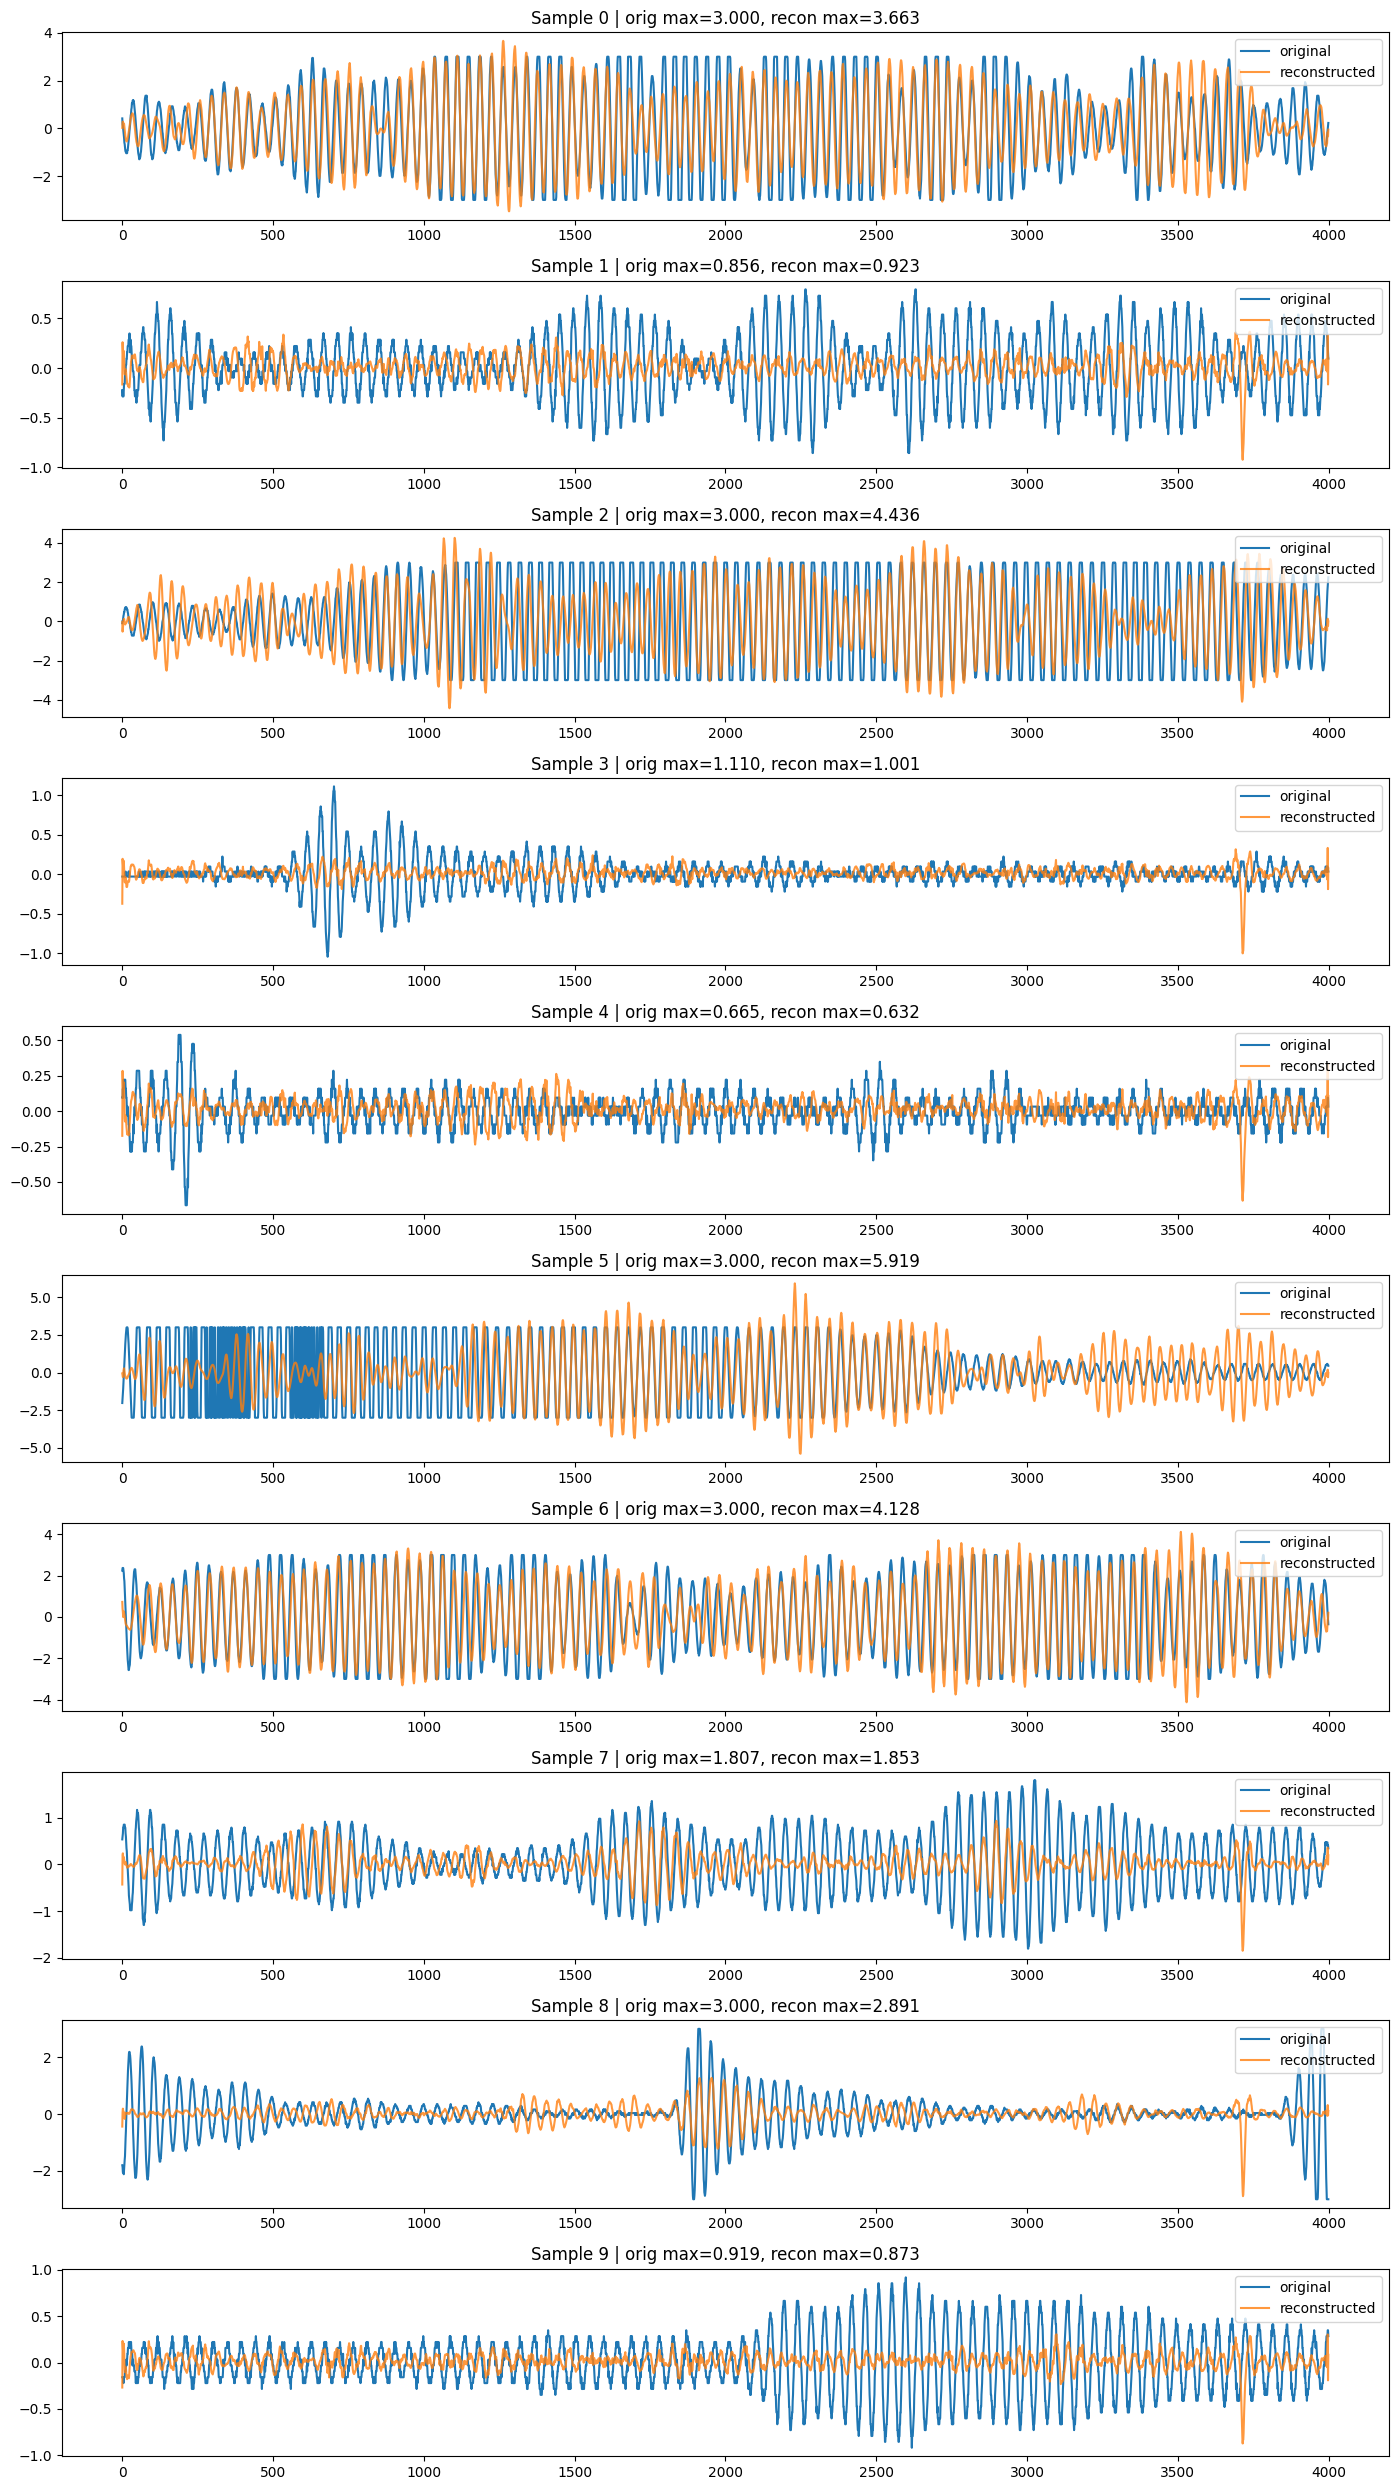

--- Sample 0 | orig max 3.0000 | recon max 3.6634 ---


--- Sample 1 | orig max 0.8557 | recon max 0.9231 ---


--- Sample 2 | orig max 3.0000 | recon max 4.4356 ---


--- Sample 3 | orig max 1.1095 | recon max 1.0014 ---


--- Sample 4 | orig max 0.6646 | recon max 0.6324 ---


--- Sample 5 | orig max 3.0000 | recon max 5.9194 ---


--- Sample 6 | orig max 3.0000 | recon max 4.1283 ---


--- Sample 7 | orig max 1.8066 | recon max 1.8526 ---


--- Sample 8 | orig max 3.0000 | recon max 2.8907 ---


--- Sample 9 | orig max 0.9185 | recon max 0.8726 ---


In [7]:
# 7. Reconstruction evaluation + audio
data_cfg = config['data']
wav_files = collect_clean_wavs(DATA_DIR)
N = len(wav_files)
perm = np.random.permutation(N)
split = int(data_cfg['train_split'] * N)
val_files = [wav_files[i] for i in perm[split:]]
train_files = [wav_files[i] for i in perm[:split]]
global_rms = estimate_global_rms(train_files, n=200, sr_expect=data_cfg['sr'])

val_ds = HapticWavDataset(val_files, T=data_cfg['T'], sr_expect=data_cfg['sr'], global_rms=global_rms, scale=data_cfg['scale'])
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cfg = config['model']
model = ConvVAE(
    T=data_cfg['T'], latent_dim=model_cfg['latent_dim'],
    channels=tuple(model_cfg['channels']),
    first_kernel=model_cfg.get('first_kernel', 25),
    kernel_size=model_cfg.get('kernel_size', 9),
).to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

result = evaluate_reconstruction(model, val_loader, device, n_samples=10)
print_metrics(result)
plot_waveform_comparison(result['x_np'], result['xhat_np'])
play_ab_comparison(result['x_np'], result['xhat_np'], sr=data_cfg['sr'])

---
## PCA Control Pipeline

Extract latent vectors from the full dataset, fit PCA to get 8 interpretable control dimensions, and run sweep experiments.

In [8]:
# 8. Extract latent vectors + fit PCA
PCA_DIR = "/content/outputs/pca"

!python scripts/extract_and_pca.py \
    --config {CONFIG} \
    --data_dir {DATA_DIR} \
    --checkpoint {ckpt_path} \
    --output_dir {PCA_DIR} \
    --n_components 8

✅ Loaded checkpoint: /content/outputs/vae_balanced/best_model.pt
   Latent dim: 24, Dataset size: 585

STEP 1: Extracting latent vectors (mu)
Extracted latent vectors: shape=(585, 24), mean=-0.0433, std=1.5981, min=-7.5676, max=8.3567
  Saved: /content/outputs/pca/Z.npy

STEP 2: PCA (24D → 8D)

PCA Results (24D → 8D):
--------------------------------------------------
  PC1: 0.2134 (21.34%)  cumulative: 21.34%
  PC2: 0.0911 (9.11%)  cumulative: 30.46%
  PC3: 0.0570 (5.70%)  cumulative: 36.16%
  PC4: 0.0513 (5.13%)  cumulative: 41.29%
  PC5: 0.0493 (4.93%)  cumulative: 46.23%
  PC6: 0.0459 (4.59%)  cumulative: 50.82%
  PC7: 0.0443 (4.43%)  cumulative: 55.25%
  PC8: 0.0424 (4.24%)  cumulative: 59.49%
--------------------------------------------------
  Total explained variance: 59.49%
  Z_pca shape: (585, 8)

  Saved: /content/outputs/pca/pca_pipe.pkl
  Saved: /content/outputs/pca/Z_pca.npy

🏁 All outputs saved to: /content/outputs/pca



Sweeping PC1 from -2 to +2


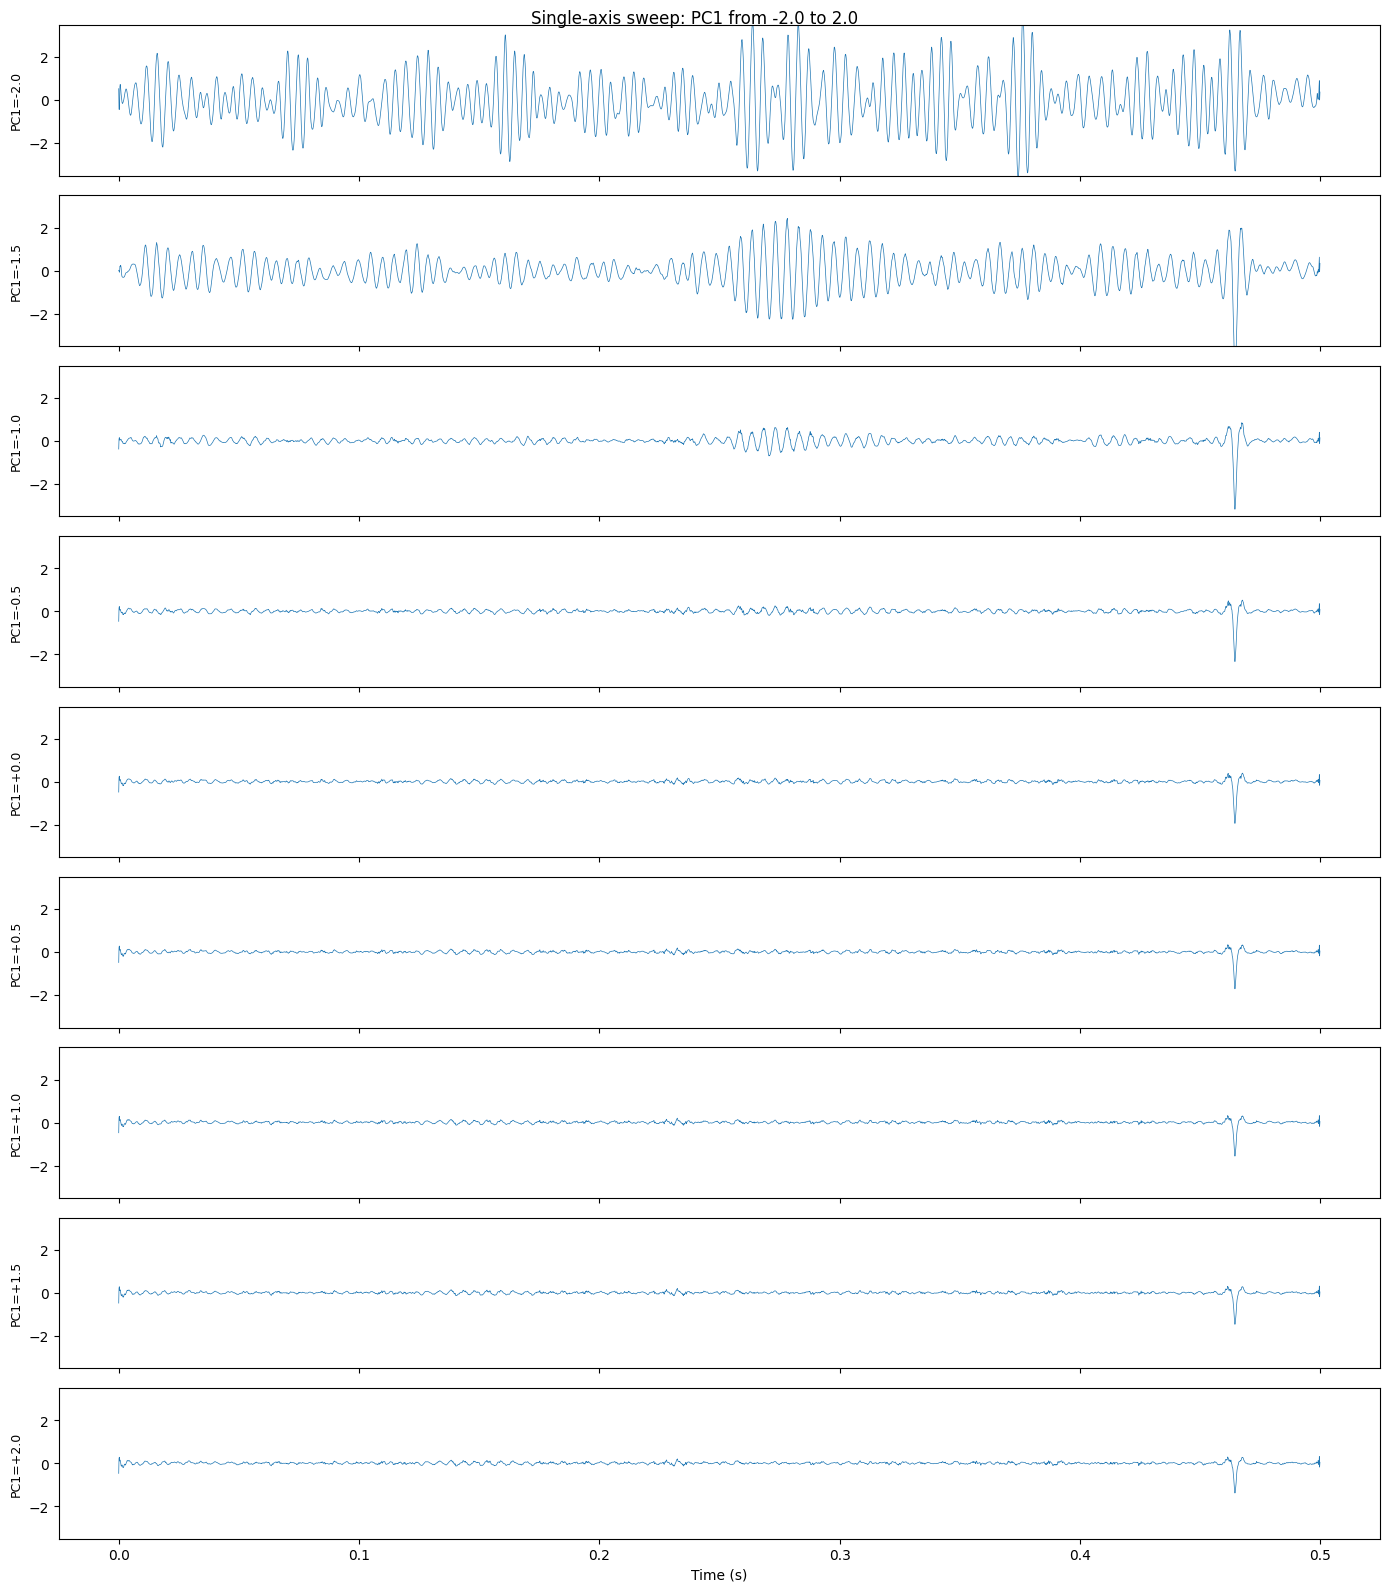

PC1 = -2.00  |  max=3.9745


PC1 = -1.50  |  max=4.8348


PC1 = -1.00  |  max=3.1707


PC1 = -0.50  |  max=2.3313


PC1 = +0.00  |  max=1.9313


PC1 = +0.50  |  max=1.7019


PC1 = +1.00  |  max=1.5572


PC1 = +1.50  |  max=1.4540


PC1 = +2.00  |  max=1.3761



Sweeping PC2 from -2 to +2


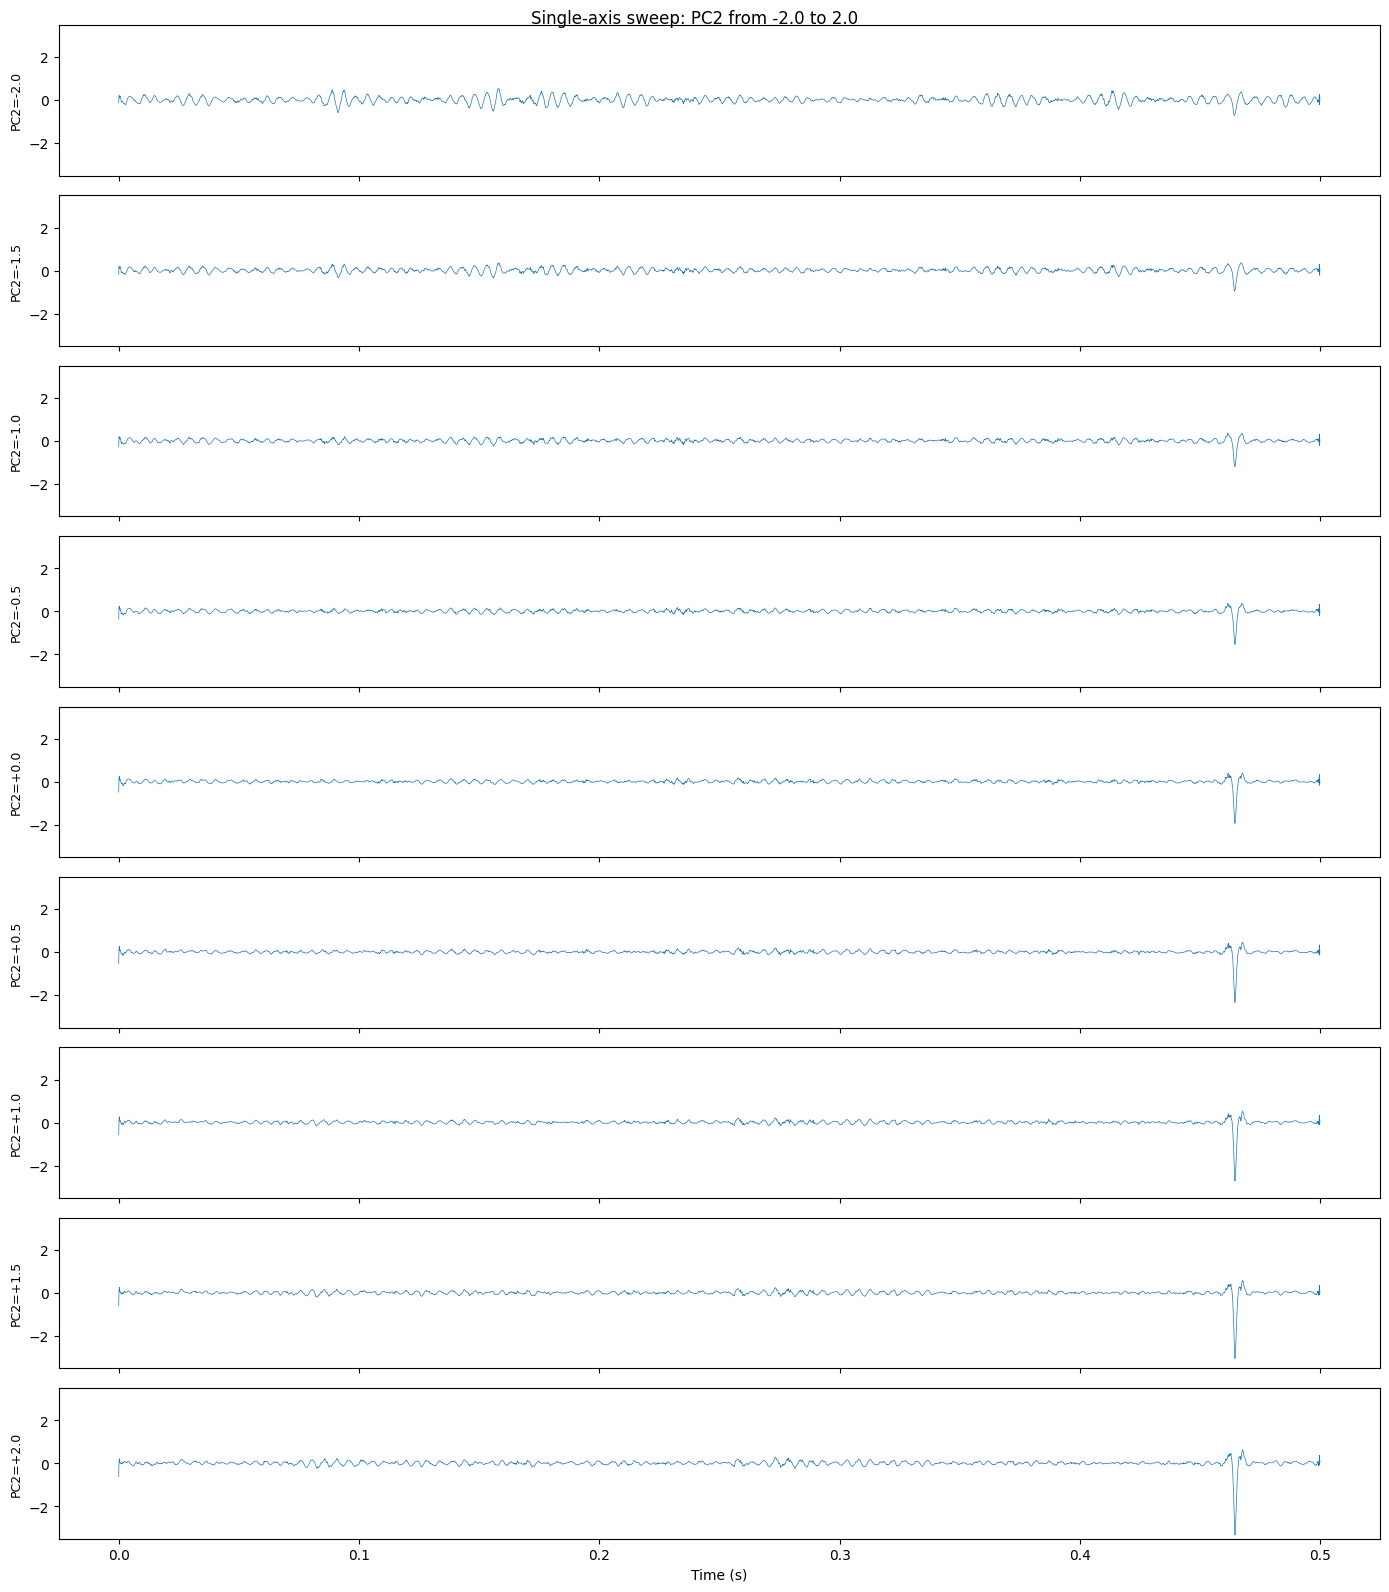

PC2 = -2.00  |  max=0.7053


PC2 = -1.50  |  max=0.9495


PC2 = -1.00  |  max=1.1874


PC2 = -0.50  |  max=1.5284


PC2 = +0.00  |  max=1.9313


PC2 = +0.50  |  max=2.3356


PC2 = +1.00  |  max=2.7170


PC2 = +1.50  |  max=3.0457


PC2 = +2.00  |  max=3.3212



Sweeping PC3 from -2 to +2


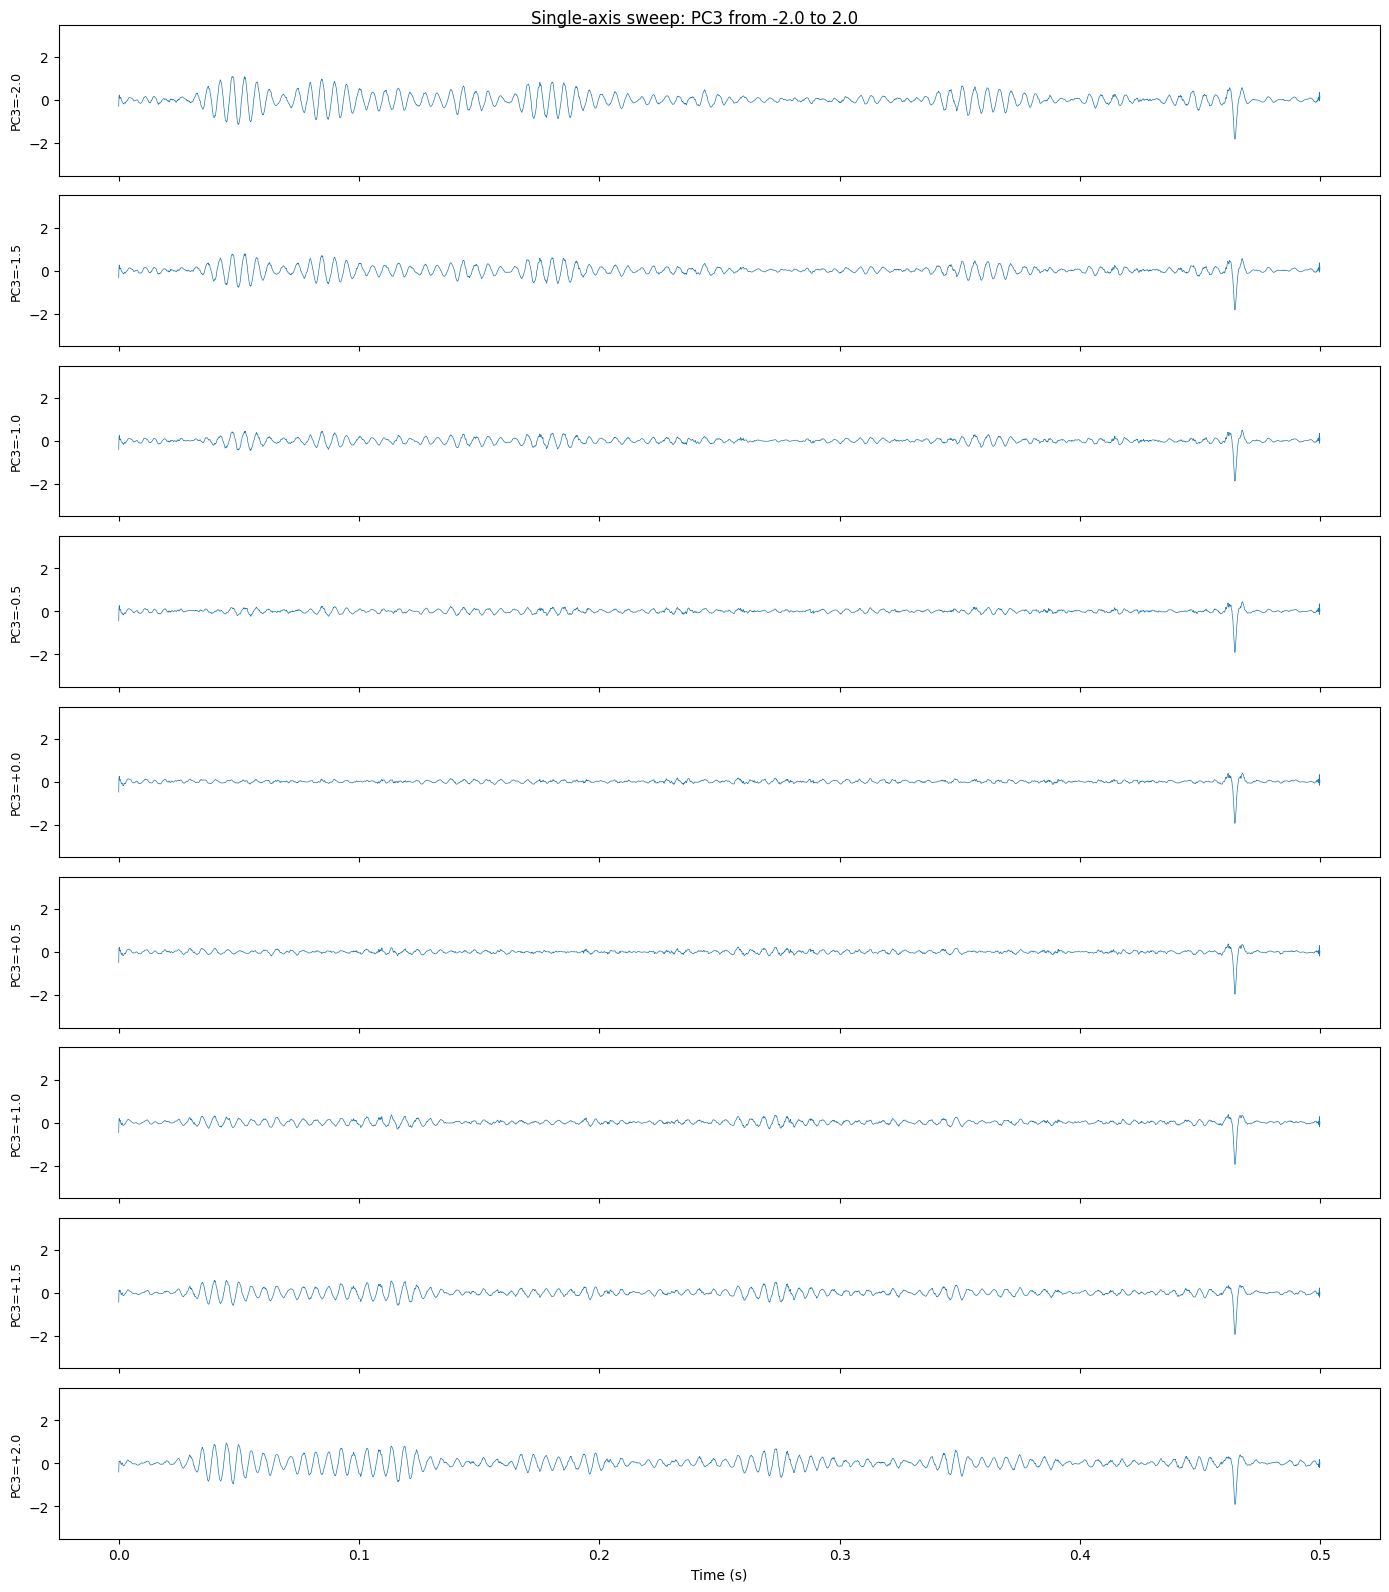

PC3 = -2.00  |  max=1.8020


PC3 = -1.50  |  max=1.8257


PC3 = -1.00  |  max=1.8615


PC3 = -0.50  |  max=1.9001


PC3 = +0.00  |  max=1.9313


PC3 = +0.50  |  max=1.9472


PC3 = +1.00  |  max=1.9395


PC3 = +1.50  |  max=1.9223


PC3 = +2.00  |  max=1.9035



Sweeping PC4 from -2 to +2


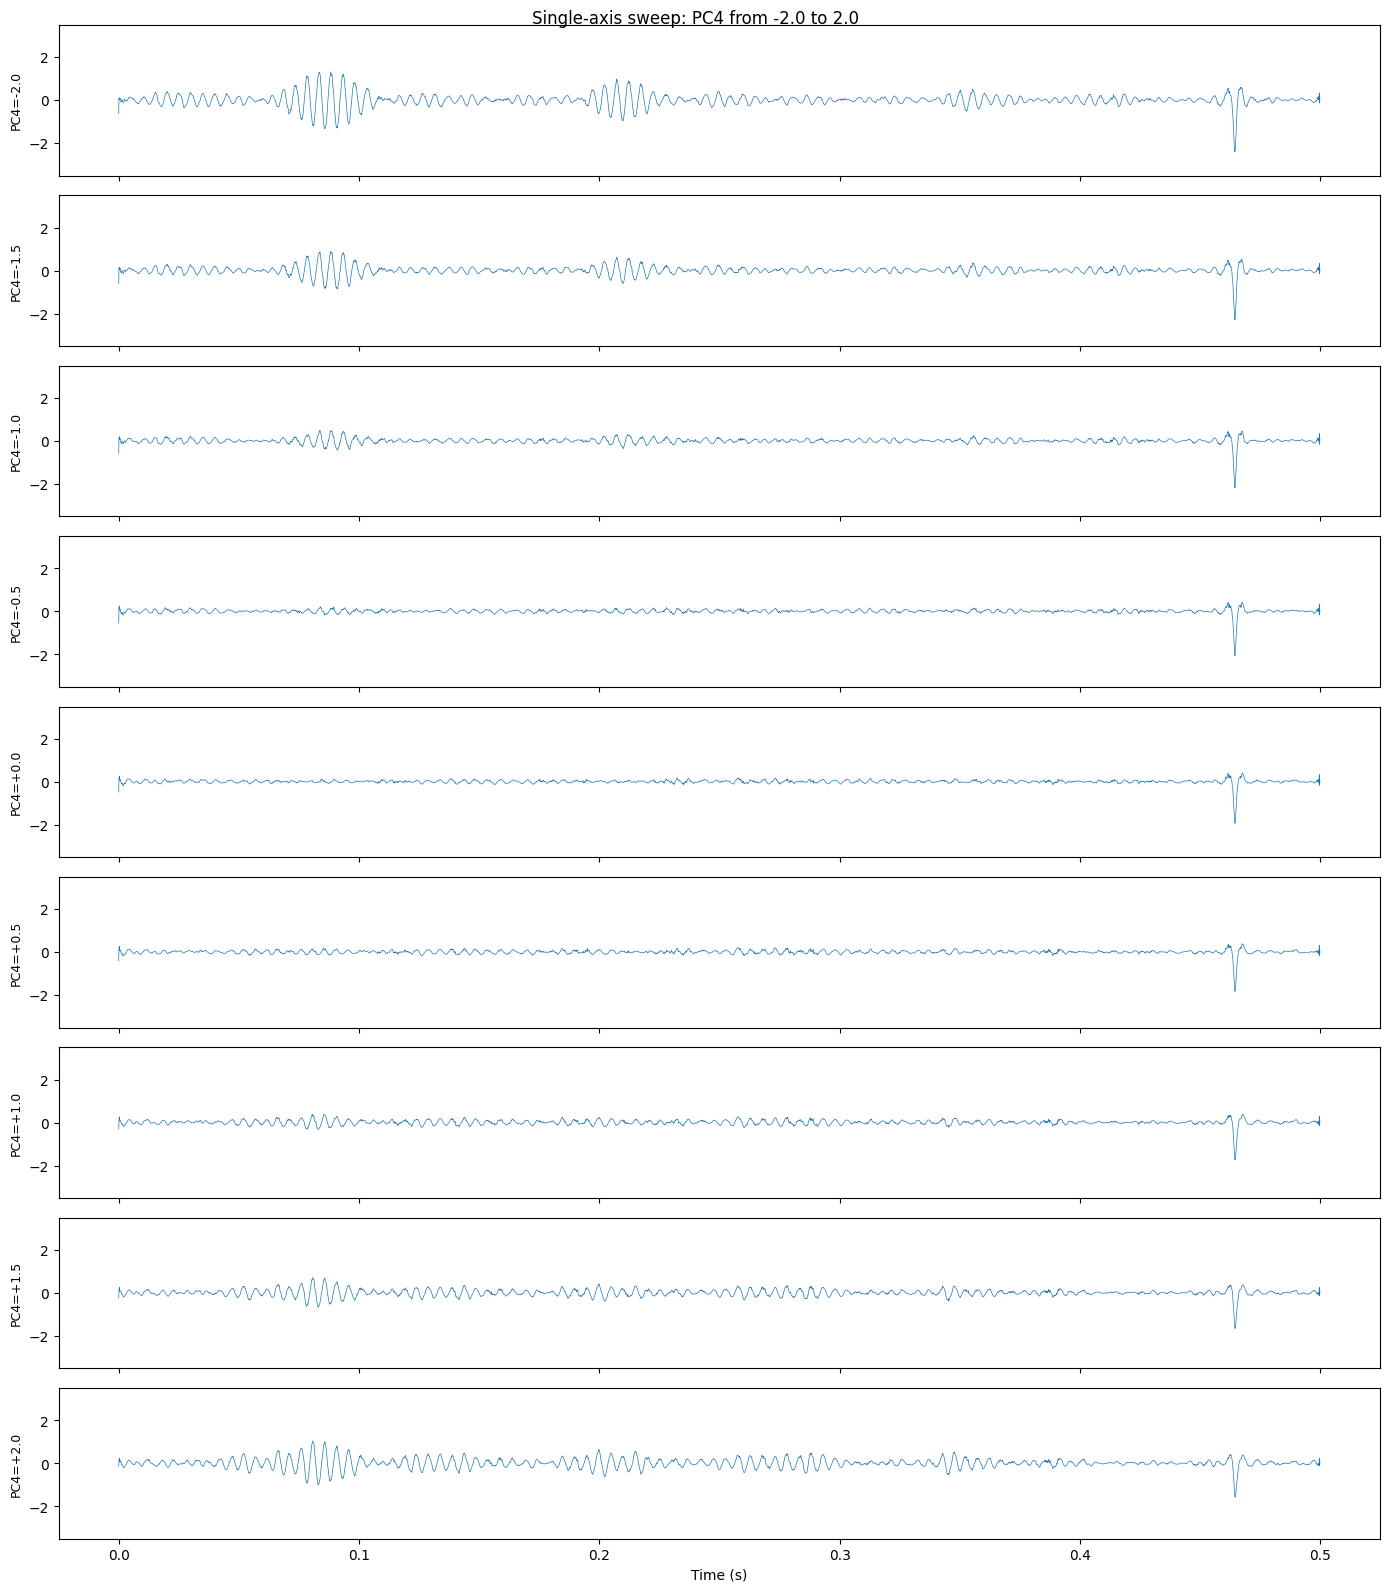

PC4 = -2.00  |  max=2.3919


PC4 = -1.50  |  max=2.2890


PC4 = -1.00  |  max=2.1773


PC4 = -0.50  |  max=2.0582


PC4 = +0.00  |  max=1.9313


PC4 = +0.50  |  max=1.8238


PC4 = +1.00  |  max=1.7323


PC4 = +1.50  |  max=1.6452


PC4 = +2.00  |  max=1.5621


In [9]:
# 9. Single-axis sweep: visualize what each PC controls
import pickle
from src.pipelines.pca_control import single_axis_sweep, plot_sweep, play_sweep

with open(f"{PCA_DIR}/pca_pipe.pkl", "rb") as f:
    pipe = pickle.load(f)

# Sweep PC1 through PC4 (most important axes)
for ax in range(4):
    print(f"\n{'='*60}")
    print(f"Sweeping PC{ax+1} from -2 to +2")
    print(f"{'='*60}")
    result = single_axis_sweep(
        pipe, model, device,
        axis=ax, sweep_range=(-2.0, 2.0), n_steps=9,
        T=data_cfg['T'],
    )
    plot_sweep(result, sr=data_cfg['sr'])
    play_sweep(result, sr=data_cfg['sr'])

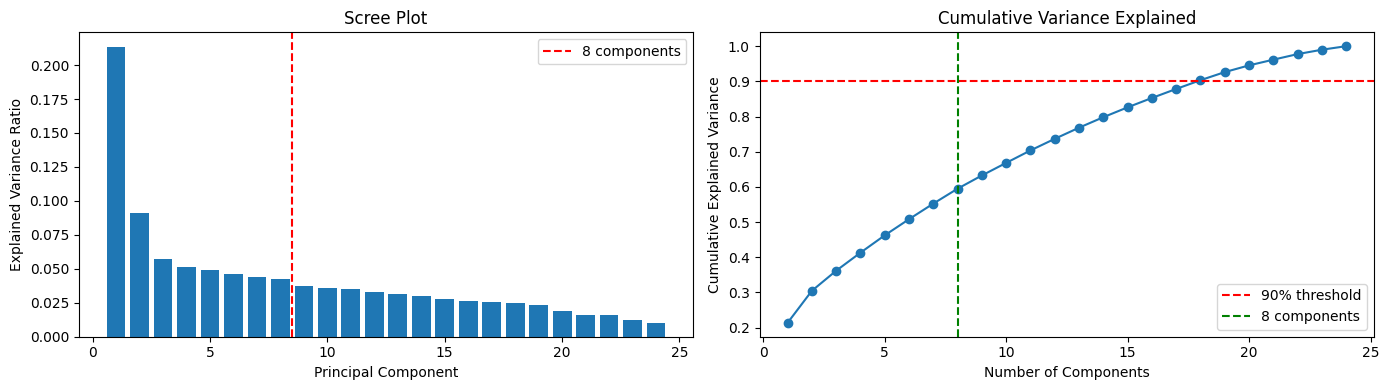


Variance explained by 8 PCs: 59.49%
Variance explained by 16 PCs: 85.28%
Components needed for 90%: 18


In [10]:
# 10. Inspect PCA: variance explained and control space statistics
Z = np.load(f"{PCA_DIR}/Z.npy")
Z_pca = np.load(f"{PCA_DIR}/Z_pca.npy")

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Full PCA to see variance dropoff
from sklearn.preprocessing import StandardScaler
Z_scaled = StandardScaler().fit_transform(Z)
full_pca = PCA().fit(Z_scaled)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Scree plot
ax1.bar(range(1, len(full_pca.explained_variance_ratio_)+1), full_pca.explained_variance_ratio_)
ax1.axvline(x=8.5, color='r', linestyle='--', label='8 components')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot')
ax1.legend()

# Cumulative variance
cumvar = np.cumsum(full_pca.explained_variance_ratio_)
ax2.plot(range(1, len(cumvar)+1), cumvar, 'o-')
ax2.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
ax2.axvline(x=8, color='g', linestyle='--', label='8 components')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Variance Explained')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nVariance explained by 8 PCs: {cumvar[7]:.2%}")
print(f"Variance explained by 16 PCs: {cumvar[15]:.2%}")
print(f"Components needed for 90%: {np.argmax(cumvar >= 0.9) + 1}")

---
## Freeze Controls: Specification + Gallery

Build the frozen control interface:
- Compute P5–P95 ranges from training data (not arbitrary -2/+2)
- Quantify what each PC controls via signal metrics
- Generate `controls_spec.json`, `controls_table.md`, and sweep gallery

In [11]:
# 11. Build frozen control specification
CTRL_DIR = "/content/outputs/controls"

!python scripts/build_controls.py \
    --config {CONFIG} \
    --data_dir {DATA_DIR} \
    --checkpoint {ckpt_path} \
    --output_dir {CTRL_DIR} \
    --pca_dir {PCA_DIR} \
    --n_components 8 \
    --n_sweep_steps 11

✅ Loaded checkpoint: /content/outputs/vae_balanced/best_model.pt
   Latent dim: 24, Dataset size: 585

📦 Loading existing PCA from /content/outputs/pca

Building control specification
Saved: /content/outputs/controls/controls_spec.json

Generating sweep gallery (waveform + spectrogram)
  PC1: sweeping [-5.66, +1.98]
  PC2: sweeping [-2.38, +2.32]
  PC3: sweeping [-1.79, +1.91]
  PC4: sweeping [-1.92, +1.74]
  PC5: sweeping [-1.70, +1.73]
  PC6: sweeping [-1.56, +1.60]
  PC7: sweeping [-1.61, +1.83]
  PC8: sweeping [-1.70, +1.70]
  Saved: /content/outputs/controls/pc_sweep_gallery/sweep_PC1.png
Figure(1600x1760)
  Saved: /content/outputs/controls/pc_sweep_gallery/sweep_PC2.png
Figure(1600x1760)
  Saved: /content/outputs/controls/pc_sweep_gallery/sweep_PC3.png
Figure(1600x1760)
  Saved: /content/outputs/controls/pc_sweep_gallery/sweep_PC4.png
Figure(1600x1760)
  Saved: /content/outputs/controls/pc_sweep_gallery/sweep_PC5.png
Figure(1600x1760)
  Saved: /content/outputs/controls/pc_sweep_g

In [12]:
# 12. View controls_spec.json
import json

with open(f"{CTRL_DIR}/controls_spec.json") as f:
    spec = json.load(f)

print(f"Controls: {spec['n_controls']}")
print(f"Total explained variance: {spec['total_explained_variance_pct']:.1f}%")
print()
for ctrl in spec['controls']:
    r = ctrl['range']
    dom = ctrl['dominant_metrics'][0]
    print(f"  {ctrl['name']}: [{r['low']:+.2f}, {r['high']:+.2f}]  "
          f"var={ctrl['explained_variance_pct']:.1f}%  "
          f"primary={dom['metric']} ({dom['direction']})")

Controls: 8
Total explained variance: 59.5%

  PC1: [-5.66, +1.98]  var=21.3%  primary=ioi_entropy_bits (increases)
  PC2: [-2.38, +2.32]  var=9.1%  primary=ioi_entropy_bits (decreases)
  PC3: [-1.79, +1.91]  var=5.7%  primary=ioi_entropy_bits (decreases)
  PC4: [-1.92, +1.74]  var=5.1%  primary=ioi_entropy_bits (decreases)
  PC5: [-1.70, +1.73]  var=4.9%  primary=ioi_entropy_bits (increases)
  PC6: [-1.56, +1.60]  var=4.6%  primary=ioi_entropy_bits (decreases)
  PC7: [-1.61, +1.83]  var=4.4%  primary=ioi_entropy_bits (decreases)
  PC8: [-1.70, +1.70]  var=4.2%  primary=envelope_decay_slope_dBps (increases)


In [13]:
# 13. View controls_table.md
from IPython.display import Markdown, display

with open(f"{CTRL_DIR}/controls_table.md") as f:
    display(Markdown(f.read()))

# Haptic Control Dimensions (PC1–PC8)

Total explained variance: **59.5%**  
Signal: 4000 samples @ 8000 Hz (0.50s)

## Control Summary

| Control | Var% | Range (P5–P95) | Primary Effect | Direction |
|---------|------|----------------|---------------|-----------|
| PC1 | 21.3 | [-5.66, +1.98] | IOI entropy | increases |
| PC2 | 9.1 | [-2.38, +2.32] | IOI entropy | decreases |
| PC3 | 5.7 | [-1.79, +1.91] | IOI entropy | decreases |
| PC4 | 5.1 | [-1.92, +1.74] | IOI entropy | decreases |
| PC5 | 4.9 | [-1.70, +1.73] | IOI entropy | increases |
| PC6 | 4.6 | [-1.56, +1.60] | IOI entropy | decreases |
| PC7 | 4.4 | [-1.61, +1.83] | IOI entropy | decreases |
| PC8 | 4.2 | [-1.70, +1.70] | Envelope decay slope | increases |

## Detailed Metric Profiles

### PC1 — 21.3% variance

- Range (P5–P95): [-5.66, +1.98]
- Data mean: -0.0000, std: 2.2633

| Metric | Direction | Relative Change | Range |
|--------|-----------|-----------------|-------|
| IOI entropy | increases | 11.00x | [-0.000, 0.384] bits |
| HF energy ratio | increases | 3.30x | [0.000, 0.038] |
| Onset density | increases | 3.00x | [0.000, 6.000] /s |

### PC2 — 9.1% variance

- Range (P5–P95): [-2.38, +2.32]
- Data mean: 0.0000, std: 1.4789

| Metric | Direction | Relative Change | Range |
|--------|-----------|-----------------|-------|
| IOI entropy | decreases | 5.70x | [-0.000, 0.722] bits |
| Envelope decay slope | increases | 2.52x | [-1.278, 7.184] dB/s |
| Short-term variance | increases | 2.21x | [0.001, 0.009] |

### PC3 — 5.7% variance

- Range (P5–P95): [-1.79, +1.91]
- Data mean: 0.0000, std: 1.1700

| Metric | Direction | Relative Change | Range |
|--------|-----------|-----------------|-------|
| IOI entropy | decreases | 2.71x | [-0.000, 1.213] bits |
| Envelope decay slope | increases | 2.54x | [-18.262, 6.126] dB/s |
| Late/Early energy ratio | increases | 2.42x | [0.378, 5.581] |

### PC4 — 5.1% variance

- Range (P5–P95): [-1.92, +1.74]
- Data mean: 0.0000, std: 1.1098

| Metric | Direction | Relative Change | Range |
|--------|-----------|-----------------|-------|
| IOI entropy | decreases | 3.70x | [-0.000, 0.927] bits |
| Short-term variance | decreases | 3.43x | [0.002, 0.021] |
| Envelope decay slope | decreases | 2.85x | [-17.534, 5.618] dB/s |

### PC5 — 4.9% variance

- Range (P5–P95): [-1.70, +1.73]
- Data mean: -0.0000, std: 1.0882

| Metric | Direction | Relative Change | Range |
|--------|-----------|-----------------|-------|
| IOI entropy | increases | 5.50x | [-0.000, 0.983] bits |
| Envelope decay slope | decreases | 3.37x | [-6.919, 5.444] dB/s |
| Short-term variance | decreases | 2.68x | [0.002, 0.019] |

### PC6 — 4.6% variance

- Range (P5–P95): [-1.56, +1.60]
- Data mean: -0.0000, std: 1.0495

| Metric | Direction | Relative Change | Range |
|--------|-----------|-----------------|-------|
| IOI entropy | decreases | 11.00x | [-0.000, 1.249] bits |
| Short-term variance | increases | 2.38x | [0.002, 0.011] |
| Low/High band ratio | increases | 1.99x | [41.630, 192.971] |

### PC7 — 4.4% variance

- Range (P5–P95): [-1.61, +1.83]
- Data mean: 0.0000, std: 1.0310

| Metric | Direction | Relative Change | Range |
|--------|-----------|-----------------|-------|
| IOI entropy | decreases | 8.04x | [-0.000, 0.977] bits |
| Short-term variance | increases | 4.03x | [0.002, 0.030] |
| Envelope decay slope | increases | 3.29x | [-8.996, 4.985] dB/s |

### PC8 — 4.2% variance

- Range (P5–P95): [-1.70, +1.70]
- Data mean: 0.0000, std: 1.0090

| Metric | Direction | Relative Change | Range |
|--------|-----------|-----------------|-------|
| Envelope decay slope | increases | 3.46x | [-6.342, 7.931] dB/s |
| IOI entropy | decreases | 2.74x | [-0.000, 0.982] bits |
| Short-term variance | increases | 1.72x | [0.002, 0.010] |


In [14]:
# 14. Decode from controls — stable API demo
import pickle
from src.pipelines.pca_control import control_to_latent
from IPython.display import Audio, display

with open(f"{CTRL_DIR}/controls_spec.json") as f:
    spec = json.load(f)
with open(f"{PCA_DIR}/pca_pipe.pkl", "rb") as pf:
    pipe = pickle.load(pf)

def decode_controls(controls: list[float]) -> np.ndarray:
    """Stable API: 8 control values -> haptic signal."""
    c = np.array(controls, dtype=np.float32)
    z = control_to_latent(pipe, c)
    z_t = torch.from_numpy(z).float().unsqueeze(0).to(device)
    with torch.no_grad():
        x_hat = model.decode(z_t, target_len=data_cfg['T'])
    return x_hat.squeeze().cpu().numpy()

# Example: all zeros = neutral signal
sig_neutral = decode_controls([0, 0, 0, 0, 0, 0, 0, 0])
print(f"Neutral: RMS={np.sqrt(np.mean(sig_neutral**2)):.4f}, peak={np.max(np.abs(sig_neutral)):.4f}")
display(Audio(sig_neutral / (np.max(np.abs(sig_neutral)) + 1e-8), rate=data_cfg['sr']))

# Example: max PC1 = high energy
hi = spec['controls'][0]['range']['high']
sig_high_pc1 = decode_controls([hi, 0, 0, 0, 0, 0, 0, 0])
print(f"\nPC1={hi:+.2f}: RMS={np.sqrt(np.mean(sig_high_pc1**2)):.4f}, peak={np.max(np.abs(sig_high_pc1)):.4f}")
display(Audio(sig_high_pc1 / (np.max(np.abs(sig_high_pc1)) + 1e-8), rate=data_cfg['sr']))

Neutral: RMS=0.0997, peak=1.9313



PC1=+1.98: RMS=0.0756, peak=1.3795


---
## (Optional) Save outputs to Google Drive

Colab local storage is wiped when the session ends. Run the cell below to copy your trained model and PCA results to Google Drive.

In [ ]:
# Optional: save outputs to Google Drive for persistence
SAVE_TO_DRIVE = False  # Set to True if you want to save

if SAVE_TO_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_OUTPUT = "/content/drive/MyDrive/thesis/outputs"
    os.makedirs(DRIVE_OUTPUT, exist_ok=True)
    !cp -r {OUTPUT_DIR}/* {DRIVE_OUTPUT}/
    print(f"Saved to: {DRIVE_OUTPUT}")
else:
    print("Skipped. Set SAVE_TO_DRIVE = True to save to Google Drive.")